In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs



/Users/sandeepsangole/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
path ='Predict_Future_Sales/'
sales = pd.read_csv("Predict_Future_Sales/sales_train.csv")

item_cat = pd.read_csv(path+'item_categories.csv')
item = pd.read_csv(path+'items.csv')
sub = pd.read_csv(path+'sample_submission.csv')
shops = pd.read_csv(path+'shops.csv')
test = pd.read_csv(path+'test.csv')

In [7]:
sales.date

0          02.01.2013
1          03.01.2013
2          05.01.2013
3          06.01.2013
4          15.01.2013
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 2935849, dtype: object

In [15]:
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [16]:
print(sales.date)

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [22]:
#Agreegate to monthly level the requried metrices

monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({
    'date':['min','max'],'item_price':'mean','item_cnt_day' : 'sum'
})

# Aggregate by 'date_block_num','shop_id','item_id
# Select columns 'date','item_price','ite_cnt_day'(sales)
# Aggregation to perform on cokumnns
# min/max on date
# Avg of iten price
# sum of sales
#

monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

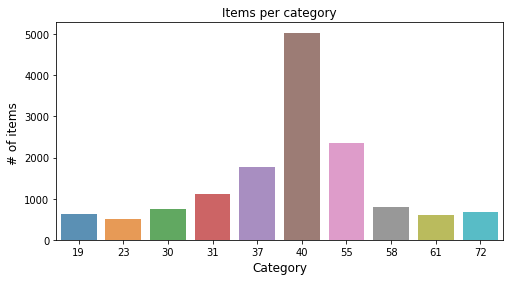

In [27]:
#number of items per cat
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.iloc[0:10].reset_index()

# PLot

plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.title("Items per category")
plt.ylabel('# of items ', fontsize = 12)
plt.xlabel('Category', fontsize=12)
plt.show()

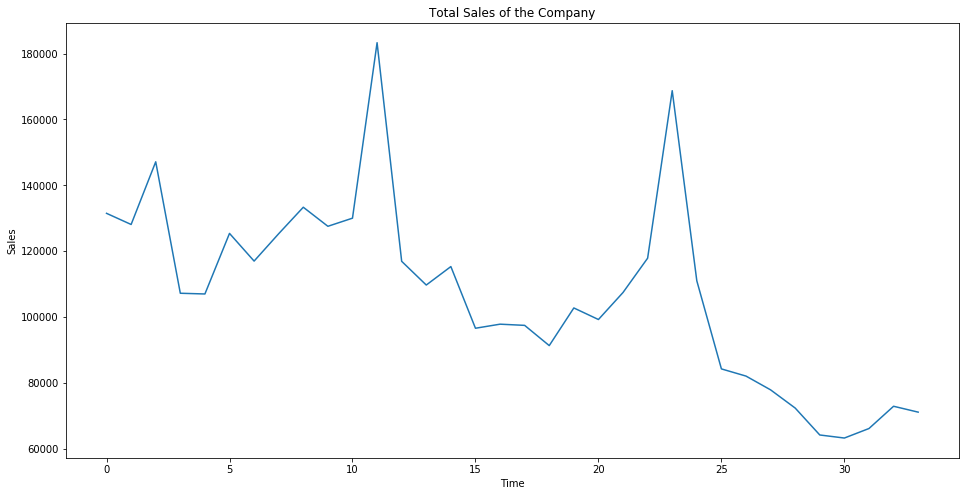

In [30]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype(float)
plt.figure(figsize = (16,8))
plt.title('Total Sales of the Company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)


In [31]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


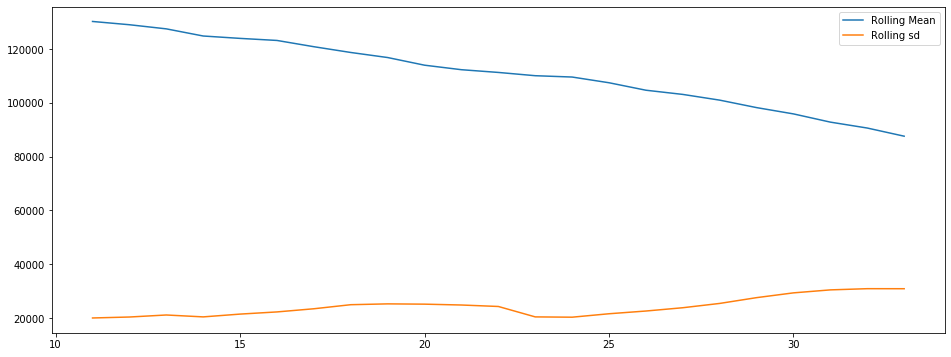

In [32]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window = 12, center = False).mean(),label = 'Rolling Mean')
plt.plot(ts.rolling(window = 12, center = False).std(),label = 'Rolling sd')
plt.legend();


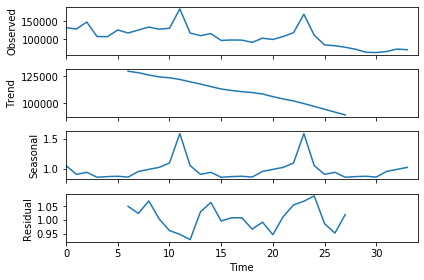

In [41]:
import statsmodels.api as sm


res = sm.tsa.seasonal_decompose(ts.values, freq=12,model = 'multiplicative')
fig = res.plot()

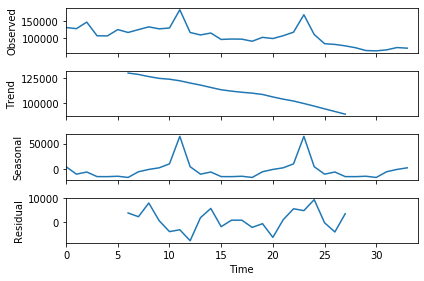

In [42]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [45]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [51]:
#to remove Trend
from pandas import Series as Series

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob


[]

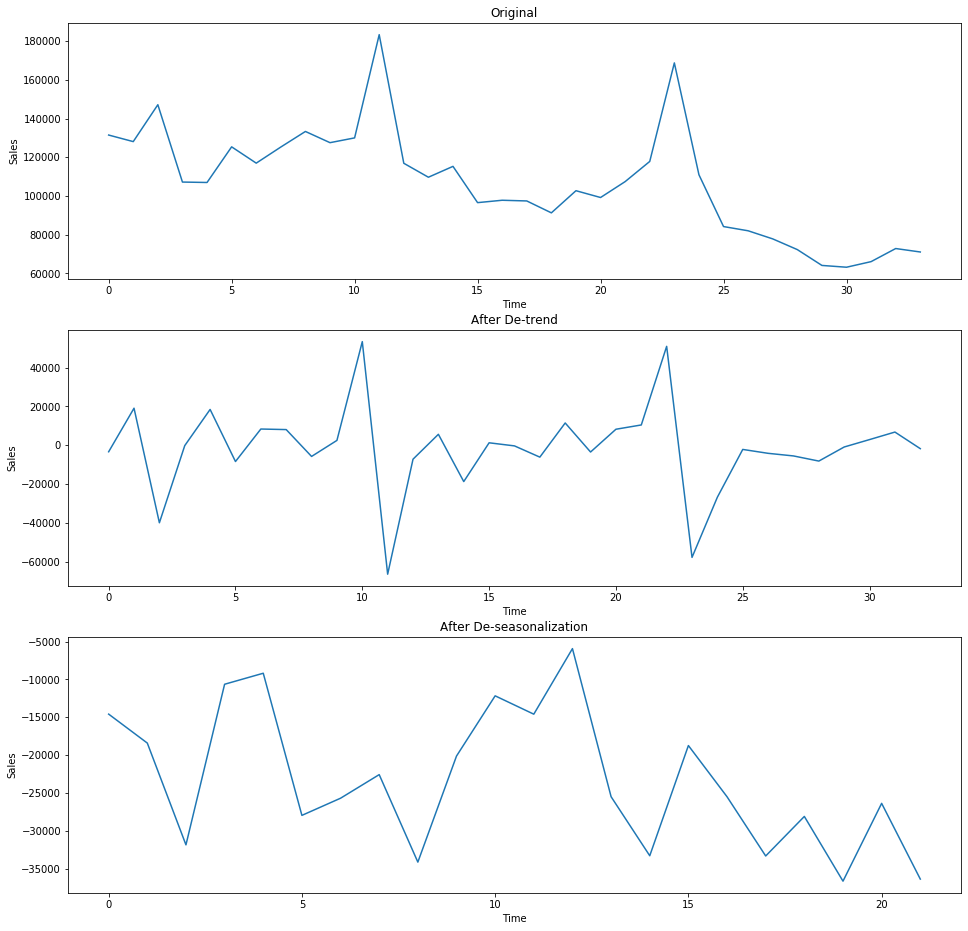

In [52]:
sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()


plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()


In [53]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

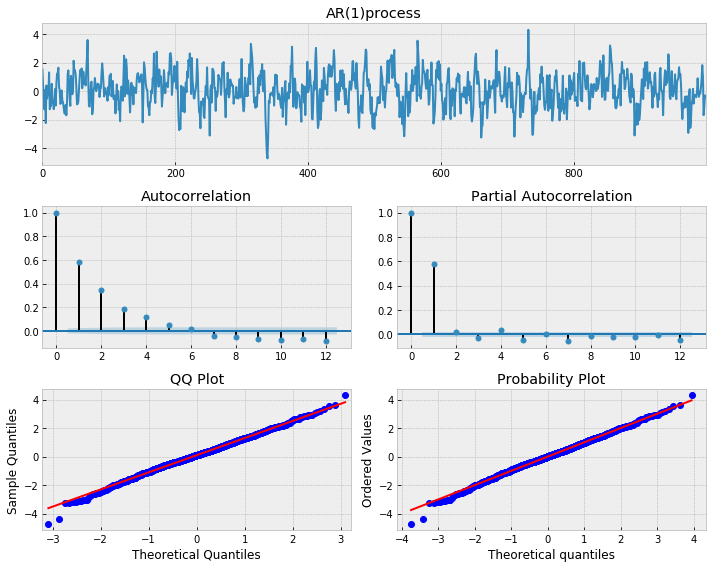

In [54]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

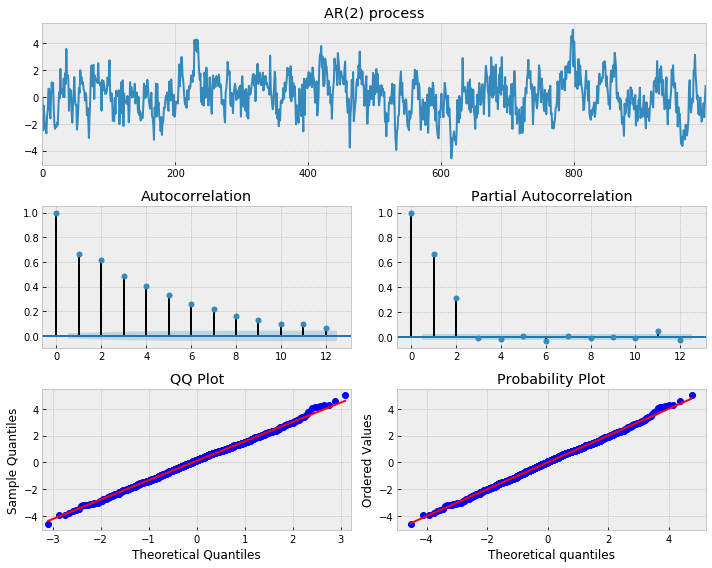

In [55]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")


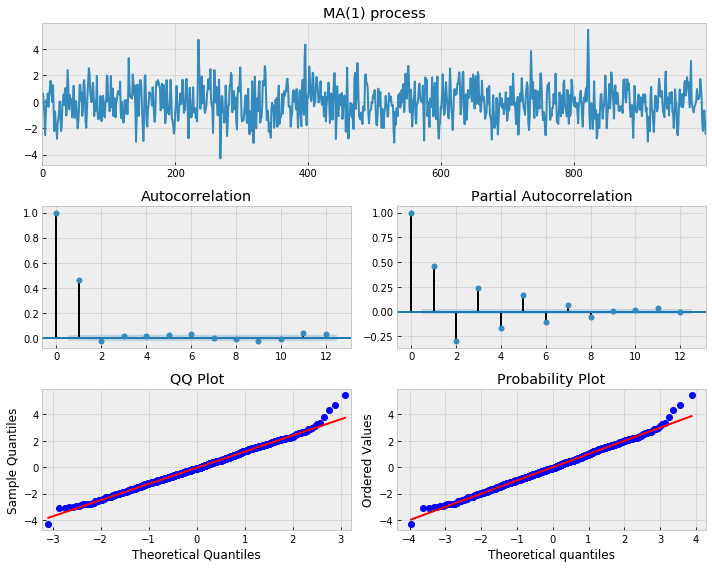

In [56]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

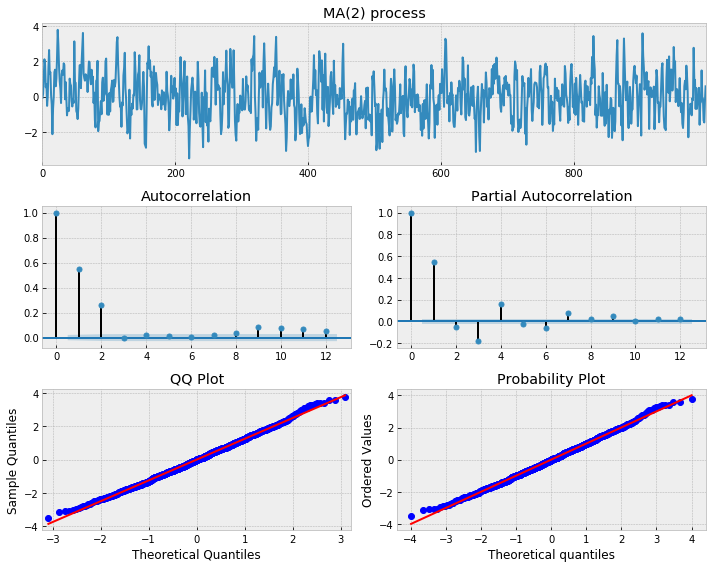

In [57]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

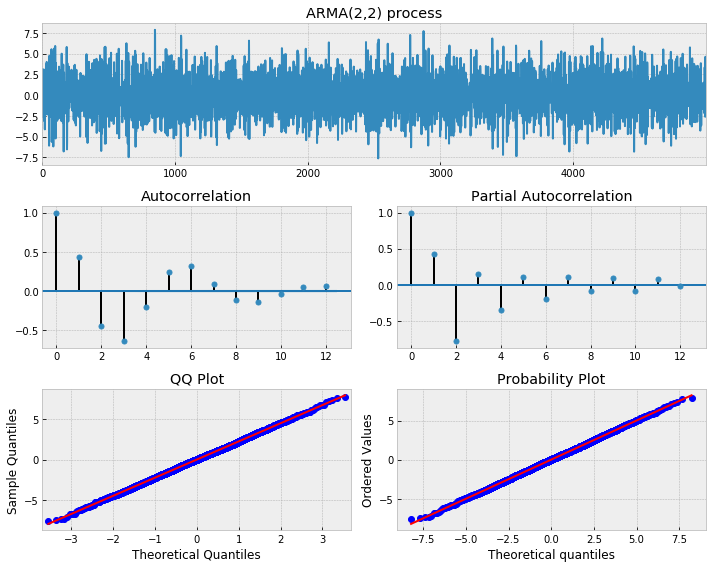

In [58]:
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")